In [8]:
from transformers import AutoModelForCausalLM
from dequant_gptq import get_pytorch_bin
import torch
import os
cur_dir = os.getcwd()
deq_model_dir = 'dequant_model'
opt = get_pytorch_bin('/home/jwjeong/.cache/huggingface/hub/models--jwjeong--opt-6.7b-4bit-128g/snapshots/1ea4ce8577b3993ebca6a7308c04a6ec72a4148b/gptq_model-4bit-128g.bin')

517


In [9]:
def plot_minmax(state_dict):
    linear_opt = [
        'k_proj',
        'q_proj',
        'v_proj',
        'out_proj',
        'fc1',
        'fc2'
    ]
    layer_weight_min = {}
    layer_weight_max = {}
    for key in state_dict.keys():
        if key.split('.')[-2] in linear_opt:
            tensor = state_dict[key]
            layer_num = int(key.split('.')[3])
            if layer_num in layer_weight_min:
                layer_weight_min[layer_num] = tensor.min() if tensor.min() < layer_weight_min[layer_num] else layer_weight_min[layer_num]
                layer_weight_max[layer_num] = tensor.max() if tensor.max() > layer_weight_max[layer_num] else layer_weight_max[layer_num]
            else:
                layer_weight_min[layer_num] = tensor.min()
                layer_weight_max[layer_num] = tensor.max()

    print(f'layer_max: {layer_weight_max}')
    print(f'layer_min: {layer_weight_min}')

    y_min = []
    y_max = []
    for key in layer_weight_min.keys():
        y_min.append(layer_weight_min[key])
        y_max.append(layer_weight_max[key])

    x = list(range(len(y_min)))

    import matplotlib.pyplot as plt
    plt.plot(x, y_min)
    plt.plot(x, y_max)

In [10]:
opt

layer_max: {0: tensor(0.9390, dtype=torch.float16), 1: tensor(0.9424, dtype=torch.float16), 2: tensor(0.9331, dtype=torch.float16), 3: tensor(0.7979, dtype=torch.float16), 4: tensor(0.7520, dtype=torch.float16), 5: tensor(0.7324, dtype=torch.float16), 6: tensor(0.6538, dtype=torch.float16), 7: tensor(1., dtype=torch.float16), 8: tensor(1., dtype=torch.float16), 9: tensor(1., dtype=torch.float16), 10: tensor(1., dtype=torch.float16), 11: tensor(1.4219, dtype=torch.float16)}
layer_min: {0: tensor(-1.1582, dtype=torch.float16), 1: tensor(-1.2744, dtype=torch.float16), 2: tensor(-1.2100, dtype=torch.float16), 3: tensor(-1.1299, dtype=torch.float16), 4: tensor(-1.1143, dtype=torch.float16), 5: tensor(-1.1084, dtype=torch.float16), 6: tensor(-0.9414, dtype=torch.float16), 7: tensor(-1., dtype=torch.float16), 8: tensor(-1., dtype=torch.float16), 9: tensor(-1., dtype=torch.float16), 10: tensor(-1., dtype=torch.float16), 11: tensor(-1.2773, dtype=torch.float16)}
layer_max: {0: tensor(0.9390, dt

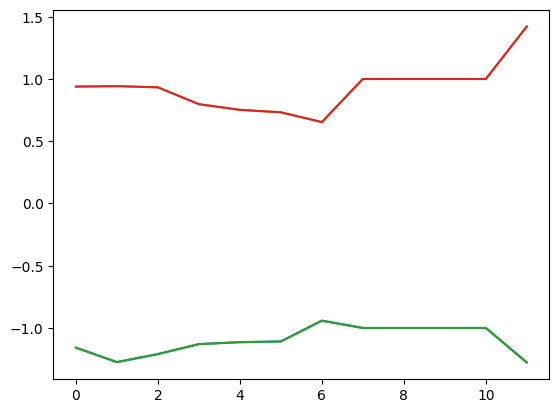

In [37]:
plot_minmax(orig_model.state_dict())
plot_minmax(quant_model)

layer_max: {0: tensor(0.9390, dtype=torch.float16), 1: tensor(0.9424, dtype=torch.float16), 2: tensor(0.9331, dtype=torch.float16), 3: tensor(0.7979, dtype=torch.float16), 4: tensor(0.7520, dtype=torch.float16), 5: tensor(0.7324, dtype=torch.float16), 6: tensor(0.6538, dtype=torch.float16), 7: tensor(1., dtype=torch.float16), 8: tensor(1., dtype=torch.float16), 9: tensor(1., dtype=torch.float16), 10: tensor(1., dtype=torch.float16), 11: tensor(1.4219, dtype=torch.float16)}
layer_min: {0: tensor(-1.1582, dtype=torch.float16), 1: tensor(-1.2744, dtype=torch.float16), 2: tensor(-1.2100, dtype=torch.float16), 3: tensor(-1.1299, dtype=torch.float16), 4: tensor(-1.1143, dtype=torch.float16), 5: tensor(-1.1084, dtype=torch.float16), 6: tensor(-0.9414, dtype=torch.float16), 7: tensor(-1., dtype=torch.float16), 8: tensor(-1., dtype=torch.float16), 9: tensor(-1., dtype=torch.float16), 10: tensor(-1., dtype=torch.float16), 11: tensor(-1.2773, dtype=torch.float16)}


In [1]:
from auto_gptq import AutoGPTQForCausalLM

repo_llama = 'TheBloke/Llama-2-7B-GPTQ'
repo_relu_llama = 'jwjeong/ReluLLaMA-7B-4bit-gptq-128g'
repo_opt_7b = 'jwjeong/opt-6.7b-4bit-128g'

/home/jwjeong/anaconda3/envs/custom/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_llama = AutoGPTQForCausalLM.from_quantized(repo_llama)

INFO - You passed a model that is compatible with the Marlin int4*fp16 GPTQ kernel but use_marlin is False. We recommend using `use_marlin=True` to use the optimized Marlin kernels for inference. Example: `model = AutoGPTQForCausalLM.from_quantized(..., use_marlin=True)`.
INFO - The layer lm_head is not quantized.
Skipping module injection for FusedLlamaMLPForQuantizedModel as currently not supported with use_triton=False.


In [12]:
qweight = model_llama.model.model.layers[0].mlp.down_proj.qweight
scales = model_llama.model.model.layers[0].mlp.down_proj.scales
qzeros = model_llama.model.model.layers[0].mlp.down_proj.qzeros
g_idx = model_llama.model.model.layers[0].mlp.down_proj.g_idx

In [15]:
print(qweight.size())
print(scales.size())
print(qzeros.size()) # 4096 / 
print(g_idx.size()) # 86 * 128

torch.Size([1376, 4096])
torch.Size([86, 4096])
torch.Size([86, 512])
torch.Size([11008])


In [3]:
model_relu_llama = AutoGPTQForCausalLM.from_quantized(repo_relu_llama)

quantize_config.json: 100%|██████████| 211/211 [00:00<00:00, 238kB/s]
gptq_model-4bit-128g.safetensors: 100%|██████████| 3.90G/3.90G [02:24<00:00, 27.0MB/s]
INFO - The layer lm_head is not quantized.
Skipping module injection for FusedLlamaMLPForQuantizedModel as currently not supported with use_triton=False.


In [4]:
model_opt_7b = AutoGPTQForCausalLM.from_quantized(repo_opt_7b)

gptq_model-4bit-128g.safetensors: 100%|██████████| 4.20G/4.20G [01:48<00:00, 38.6MB/s]
INFO - The layer lm_head is not quantized.
WARNING - OPTGPTQForCausalLM hasn't fused attention module yet, will skip inject fused attention.                
WARNING - OPTGPTQForCausalLM hasn't fused mlp module yet, will skip inject fused mlp.


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.13 GiB (GPU 4; 3.81 GiB total capacity; 3.58 GiB already allocated; 120.00 MiB free; 3.63 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF